# 價值股選股

* 本益比 <15
* PB < 1.5
* 殖利率 > 4
* 成交量 > 50%股
* C > 60MA > 120MA
* EPS 季成長
* 營收 > 前年營收

In [1]:
# initail
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union
from IPython.display import display

client = pymongo.MongoClient()
db1 = client['Index']

In [2]:
class Chast:

    def __init__(self, client, db_name='Fields'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(7, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'][self.results['BS'] < 0].count(axis=1), color='green')
            ax[2].set_title('空單持有檔數')
            ax[3].plot(self.results['BS'][self.results['BS'] > 0].count(axis=1), color='red')
            ax[3].set_title('多單持有檔數')
        if 'HOLDING' in keys:
            ax[4].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[4].set_title('累計市值')
            ax[4].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[5].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[5].grid(True)
            ax[5].set_title('Rolling Sharpe Ratio')
            ax[5].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[6].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[6].grid(True)
            ax[6].set_title('Capital')
            ax[6].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, elements,
     start: Union[datetime.datetime, None]=None, 
     end: Union[datetime.datetime, None]=None):
        """
        elements: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        
        if type(elements) != list:
            self.data[elements] = pd.DataFrame(self.db[elements].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
        else:
            for e in elements:
                self.data[e] = pd.DataFrame(self.db[e].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

    def creat_to_daily(self, df: pd.DataFrame):
        n = pd.DataFrame(columns=self.data['還原收盤價'].columns, index=self.data['還原收盤價'].index.union(df.index))
        for i in df.index:
            for c in df.columns:
                n.at[i, str(c)] = df.at[i, c]
        return n.fillna(method='ffill').loc[self.data['還原收盤價'].index, self.data['還原收盤價'].columns]

In [3]:
# Load Data
np.seterr(divide='ignore')
chast = Chast(client, 'Fields')
# TODO: 這邊更改成近四季試試
getting_list = [
    '本益比(近四季)', '股價淨值比', '還原收盤價', '成交金額(千)', '殖利率',
    'EPS_Q', '營業收入淨額_Q', '收盤價'
]
#getting_list = chast.db.list_collection_names()
start = datetime.datetime(2004, 1, 1)
# end = datetime.datetime(2022, 10, 11)
end = datetime.datetime.today()
# 原始資料
chast.get_from_mongo(getting_list, start, end)
chast.set_data('收盤價', chast.data['收盤價'].fillna(method='ffill'))
chast.set_data('還原收盤價', chast.data['還原收盤價'].fillna(method='ffill'))
chast.set_data('MA60', chast.data['還原收盤價'].rolling(60).mean())
chast.set_data('MA120', chast.data['還原收盤價'].rolling(120).mean())
chast.set_data('大盤收盤價', pd.DataFrame(db1['TWA00'].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all'))

# 調整後資料
log收盤價 = chast.data['還原收盤價'].copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])
chast.set_data('log收盤價', log收盤價)
chast.set_data('EPS_daily', chast.creat_to_daily(chast.data['EPS_Q'].rolling(4).sum().pct_change().replace([np.inf, -np.inf], np.nan)))
chast.set_data('營業收入淨額_daily', chast.creat_to_daily(chast.data['營業收入淨額_Q'].rolling(4).sum().pct_change().replace([np.inf, -np.inf], np.nan)))
std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
for i, v in std_level.iterrows():
    # 去除極端值
    v99 = v.quantile(.95)
    v01 = v.quantile(.05)
    mask_99 = v[v > v99].index
    mask_01 = v[v < v01].index
    std_level.loc[i, mask_99] = v99
    std_level.loc[i, mask_01] = v01
# 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=[10, 7, 4, 2 ,1]) if x.sum() != 0 else [0] * len(x), axis=0)
chast.set_data('std_level', std_level)
# 調整讓所有資料的columns一樣
idx_, col_ = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns

for k in chast.data.keys():
    if k in ['EPS_Q', '營業收入淨額_Q', '預估EPS_Q', '營業收入淨額_Y']:
        continue
    if k in ['大盤收盤價']:
        idx_ = idx_.intersection(chast.data[k].index)
    else:
        idx_ = idx_.intersection(chast.data[k].index)
        col_ = col_.intersection(chast.data[k].columns)
for k in chast.data.keys():
    if k in ['EPS_Q', '營業收入淨額_Q', '預估EPS_Q', '營業收入淨額_Y']:
        continue
    if k in ['大盤收盤價']:
        chast.data[k] = chast.data[k].loc[idx_]
    else:
        chast.data[k] = chast.data[k].loc[idx_, col_]


In [4]:
# 極端值處理
for n in ['EPS_daily', '本益比(近四季)', '營業收入淨額_daily', '股價淨值比', '殖利率']:
    for idx, row in chast.data[n].iterrows():
        mask = row[row > row.quantile(.99)].index
        chast.data[n].loc[idx, mask] = row.quantile(.99)
        mask = row[row < row.quantile(.01)].index
        chast.data[n].loc[idx, mask] = row.quantile(.01)

In [5]:
#{k: v.shape for k, v in chast.data.items()}
{k: v.index[0] for k, v in chast.data.items()}

{'本益比(近四季)': Timestamp('2004-01-02 00:00:00'),
 '股價淨值比': Timestamp('2004-01-02 00:00:00'),
 '還原收盤價': Timestamp('2004-01-02 00:00:00'),
 '成交金額(千)': Timestamp('2004-01-02 00:00:00'),
 '殖利率': Timestamp('2004-01-02 00:00:00'),
 'EPS_Q': Timestamp('2004-03-31 00:00:00'),
 '營業收入淨額_Q': Timestamp('2004-03-31 00:00:00'),
 '收盤價': Timestamp('2004-01-02 00:00:00'),
 'MA60': Timestamp('2004-01-02 00:00:00'),
 'MA120': Timestamp('2004-01-02 00:00:00'),
 '大盤收盤價': Timestamp('2004-01-02 00:00:00'),
 'log收盤價': Timestamp('2004-01-02 00:00:00'),
 'EPS_daily': Timestamp('2004-01-02 00:00:00'),
 '營業收入淨額_daily': Timestamp('2004-01-02 00:00:00'),
 'std_level': Timestamp('2004-01-02 00:00:00')}

In [6]:
long = (chast.data['本益比(近四季)'] < 15)&\
    (chast.data['股價淨值比'] < 1.5)&\
    (chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0))&\
    (chast.data['還原收盤價'] > chast.data['MA60'])&\
    (chast.data['還原收盤價'] > chast.data['MA120'])&\
    (chast.data['EPS_daily'] > 0)&\
    (chast.data['營業收入淨額_daily'] > 0)&\
    (chast.data['殖利率'] > 4)
long = long.shift(1)

In [7]:
short = (chast.data['本益比(近四季)'] > 15)&\
    (chast.data['股價淨值比'] > 1.5)&\
    (chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0))&\
    (chast.data['還原收盤價'] < chast.data['MA60'])&\
    (chast.data['還原收盤價'] < chast.data['MA120'])&\
    (chast.data['EPS_daily'] < 0)&\
    (chast.data['營業收入淨額_daily'] < 0)&\
    (chast.data['殖利率'] < 2)
short = short.shift(1)

In [8]:
print((chast.data['本益比(近四季)'] < 15).sum(axis=1).mean())
print((chast.data['股價淨值比'] < 1.5).sum(axis=1).mean())
print((chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0)).sum(axis=1).mean())
print((chast.data['還原收盤價'] > chast.data['MA60']).sum(axis=1).mean())
print((chast.data['還原收盤價'] > chast.data['MA120']).sum(axis=1).mean())
print((chast.data['EPS_daily'] > 0).sum(axis=1).mean())
print((chast.data['營業收入淨額_daily'] > 0).sum(axis=1).mean())
print((chast.data['殖利率'] > 4).sum(axis=1).mean())

print('\n--')
print((chast.data['本益比(近四季)'] > 15).sum(axis=1).mean())
print((chast.data['股價淨值比'] > 1.5).sum(axis=1).mean())
print((chast.data['成交金額(千)'].ge(chast.data['成交金額(千)'].median(axis=1), axis=0)).sum(axis=1).mean())
print((chast.data['還原收盤價'] < chast.data['MA60']).sum(axis=1).mean())
print((chast.data['還原收盤價'] < chast.data['MA120']).sum(axis=1).mean())
print((chast.data['EPS_daily'] < 0).sum(axis=1).mean())
print((chast.data['營業收入淨額_daily'] < 0).sum(axis=1).mean())
print((chast.data['殖利率'] < 2).sum(axis=1).mean())

518.062324778952
799.1850334267846
723.9935302997628
728.312917834807
730.9730429156782
626.189346560276
733.9495363381496
523.8792322622385

--
568.3804183739487
636.5695492775501
723.9935302997628
737.4925598447272
709.7642872546905
664.4705628639207
569.1106318740565
606.8921716627129


In [9]:
時間 = pd.DataFrame(index=chast.data['還原收盤價'].index, columns=chast.data['還原收盤價'].columns)
for i in chast.data['EPS_Q'].index:
    for c in chast.data['EPS_Q'].columns:
        時間.at[i, c] = chast.data['EPS_Q'].at[i, c]

月末買 = long.groupby(pd.Grouper(freq='Q')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='Q')).tail(1)
股票名稱轉換 = pd.DataFrame(client['Index']['股票名稱轉換'].find({}, {'_id': 0})).to_dict('records')[0]

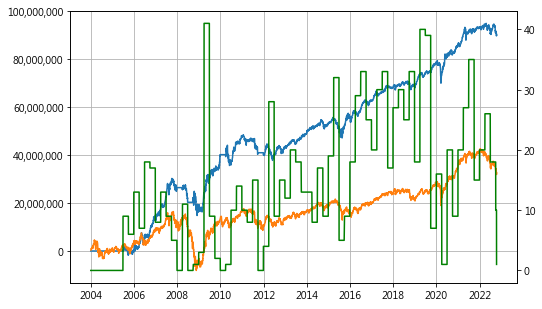

當前持倉:  {'2247': '汎德永業', '2534': '宏盛', '2702': '華園', '3231': '緯創', '3376': '新日興', '5009': '榮剛', '5534': '長虹', '8401': '白紗科', '9904': '寶成', '9907': '統一實'}
Sharpe Ratio: 1.68
MDD: -51.51 %
日期
2004-12-31            0
2005-12-31     -431,533
2006-12-31   15,357,865
2007-12-31   11,505,348
2008-12-31   -8,020,993
2009-12-31   21,768,988
2010-12-31    7,888,941
2011-12-31   -7,961,585
2012-12-31    3,393,338
2013-12-31    5,634,774
2014-12-31    4,217,796
2015-12-31    2,395,714
2016-12-31    6,810,811
2017-12-31    5,593,841
2018-12-31      377,892
2019-12-31   10,127,896
2020-12-31    7,405,439
2021-12-31    7,158,546
2022-12-31   -3,049,438
Freq: A-DEC, dtype: float64


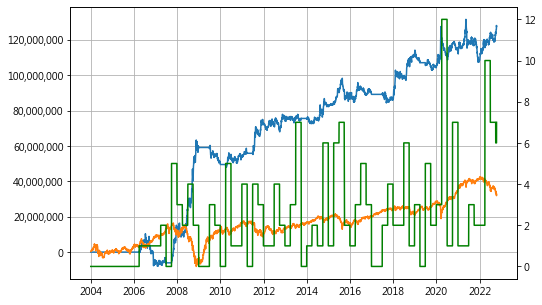

當前持倉:  {'1732': '毛寶', '1784': '訊聯', '2371': '大同', '3228': '金麗科', '6283': '淳安', '8440': '綠電'}
Sharpe Ratio: 1.58
MDD: -80.78 %
日期
2004-12-31            0
2005-12-31            0
2006-12-31   -6,892,589
2007-12-31   17,524,257
2008-12-31   48,502,439
2009-12-31   -9,621,886
2010-12-31    4,180,407
2011-12-31   18,950,164
2012-12-31    2,307,075
2013-12-31      261,882
2014-12-31    7,248,570
2015-12-31    5,017,294
2016-12-31    1,674,273
2017-12-31   -3,166,315
2018-12-31   26,334,118
2019-12-31   -7,890,361
2020-12-31    9,174,568
2021-12-31   -5,083,740
2022-12-31   19,029,556
Freq: A-DEC, dtype: float64


In [10]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=chast.data['還原收盤價'].index, columns=chast.data['還原收盤價'].columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日 = 轉日.sort_index().fillna(method='ffill')
    return 轉日

大盤損益 = chast.data['大盤收盤價'].pct_change().cumsum()

def 損益(轉日: pd.DataFrame, 買賣):
    日損益 = log收盤價.shift(-1) - log收盤價
    換股日損益 = 轉日 * 日損益 * 買賣
    進場 = 轉日 - 轉日.shift(1)
    出場 = 轉日.shift(-1) - 轉日
    費用 = 轉日.copy()
    費用.iloc[:] = 0
    費用[進場 > 0] = 0.001425
    費用[出場 < 0] = 0.004425
    換股日平均損益 = (換股日損益-費用).sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum()*30000000)
    ax.plot(大盤損益*30000000)
    ax.yaxis.set_major_formatter('{x:,.0f}')
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    持倉 = sorted(轉日.iloc[-2][轉日.iloc[-2] >= 1].index)
    print('當前持倉: ', {v: 股票名稱轉換[v] for v in 持倉})
    sr = (換股日平均損益.fillna(0).cumsum().mean()) / (換股日平均損益.fillna(0).cumsum().std())
    def maxdrawdown(se):
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        return pd.Series(mdd_, index=se.index, name='MDD')
    mdd = min(maxdrawdown(換股日平均損益.fillna(0).cumsum()))
    print('Sharpe Ratio: {:.2f}'.format(sr))
    print('MDD: {:.2f} %'.format(mdd*100))
    pd.options.display.float_format = '{:,.0f}'.format
    print(((換股日平均損益.fillna(0).groupby(pd.Grouper(freq='1y')).sum()) * 30000000))
    return 換股日平均損益


轉日月末買 = 轉日資料處理(月末買)
轉日月末賣 = 轉日資料處理(月末賣)
日買平均 = 損益(轉日月末買, 1)
日賣平均 = 損益(轉日月末賣, -1)


日期
2004-12-31            0
2005-12-31     -431,533
2006-12-31    8,465,275
2007-12-31   29,029,605
2008-12-31   40,481,447
2009-12-31   12,147,103
2010-12-31   12,069,348
2011-12-31   10,988,579
2012-12-31    5,700,414
2013-12-31    5,896,656
2014-12-31   11,466,367
2015-12-31    7,413,007
2016-12-31    8,485,084
2017-12-31    2,427,526
2018-12-31   26,712,011
2019-12-31    2,237,536
2020-12-31   16,580,007
2021-12-31    2,074,806
2022-12-31   15,980,118
Freq: A-DEC, dtype: float64


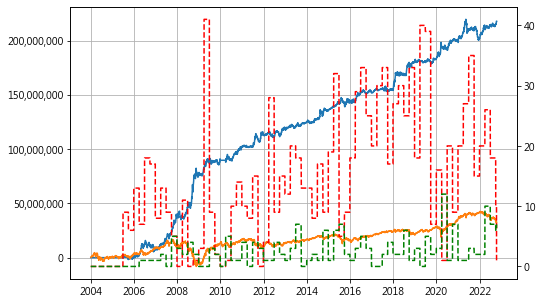

Sharpe Ratio: 1.64
MDD:          -63.21 %


In [11]:
from matplotlib.lines import lineStyles


fig, ax = plt.subplots(figsize=(8, 5))
ax1 = ax.twinx()


pf = (日買平均.fillna(0) + 日賣平均.fillna(0)).cumsum()
ax.plot(pf*30000000)
ax.plot(大盤損益*30000000)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax1.plot(轉日月末買.sum(axis=1), color='red', linestyle='--')
ax1.plot(轉日月末賣.sum(axis=1), color='green', linestyle='--')
ax.grid()
print((((日買平均.fillna(0) + 日賣平均.fillna(0)).groupby(pd.Grouper(freq='1y')).sum()*30000000)))
sr = (pf.mean()) / (pf.std())
def maxdrawdown(se):
    mdd = 0
    mdd_ = list()
    h = 0
    for i in se:
        if i > h:
            h = i
        mdd = i - h
        mdd_.append(mdd)
    return pd.Series(mdd_, index=se.index, name='MDD')
mdd = min(maxdrawdown(pf))
plt.show()
print('Sharpe Ratio: {:.2f}'.format(sr))
print('MDD:          {:.2f} %'.format(mdd*100))


In [12]:
#(pf * 30000000).to_csv(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值.csv')
關鍵點 = pd.read_csv(r'C:\Users\ChastLai\Documents\Python Scripts\Output\關鍵點.csv', index_col='日期')
關鍵點.index = pd.to_datetime(關鍵點.index)

In [13]:
pfv = pd.Series(pf * 30000000)
pfd = (日買平均.fillna(0) + 日賣平均.fillna(0)) * 30000000

In [14]:
print('日損益相關性: {:.4f}'.format(pfd.corr(關鍵點['0'])))
print('月損益相關性: {:.4f}'.format(pfd.groupby(pd.Grouper(freq='m')).sum().corr(關鍵點['0'].groupby(pd.Grouper(freq='m')).sum())))
print('年損益相關性: {:.4f}'.format(pfd.groupby(pd.Grouper(freq='y')).sum().corr(關鍵點['0'].groupby(pd.Grouper(freq='y')).sum())))

日損益相關性: 0.0191
月損益相關性: 0.0405
年損益相關性: -0.1418


In [15]:
(pfd+關鍵點['0']).groupby(pd.Grouper(freq='y')).sum()['2005':]

日期
2005-12-31   14,272,312
2006-12-31   35,794,919
2007-12-31   41,495,293
2008-12-31   39,421,642
2009-12-31   32,928,512
2010-12-31   26,649,054
2011-12-31   17,915,344
2012-12-31   16,163,928
2013-12-31   21,355,066
2014-12-31   22,600,220
2015-12-31   18,024,743
2016-12-31    9,456,514
2017-12-31   16,368,299
2018-12-31   27,962,309
2019-12-31   10,860,159
2020-12-31   32,326,401
2021-12-31    3,644,681
2022-12-31   16,689,598
Freq: A-DEC, dtype: float64

In [16]:
print('     MDD變化')
print('策略:   {:,.0f}'.format(maxdrawdown(關鍵點['0'].cumsum()).min()))
print('價值股: {:,.0f}'.format(maxdrawdown(pfv).min()))
print('合併:   {:,.0f}'.format(maxdrawdown((關鍵點['0'].cumsum() + pfv)/2).min()))

     MDD變化
策略:   -15,978,267
價值股: -18,963,049
合併:   -10,089,111


In [17]:
day = -2
多單持倉 = {v: 股票名稱轉換[v] for v in sorted(轉日月末買.iloc[day][轉日月末買.iloc[day] >= 1].index)}
空單持倉 = {v: 股票名稱轉換[v] for v in sorted(轉日月末賣.iloc[day][轉日月末賣.iloc[day] >= 1].index)}

#{v: 股票名稱轉換[v] for v in sorted(轉日月末買.iloc[-1][轉日月末買.iloc[-1] >= 1].index)}
多單內容 = pd.DataFrame(list(zip(多單持倉.keys(), 多單持倉.values())), columns=['商品代號', '商品名稱'], index=range(len(多單持倉)))
空單內容 = pd.DataFrame(list(zip(空單持倉.keys(), 空單持倉.values())), columns=['商品代號', '商品名稱'], index=range(len(空單持倉)))

In [18]:
多單內容['XQ即時價格'] = [f"=@XQ|Quote!'{x}.TW-Price'" for x in 多單內容['商品代號']]
空單內容['XQ即時價格'] = [f"=@XQ|Quote!'{x}.TW-Price'" for x in 空單內容['商品代號']]
多單內容['XQ前日價格'] = [f"=@XQ|Quote!'{x}.TW-PreClose'" for x in 多單內容['商品代號']]
空單內容['XQ前日價格'] = [f"=@XQ|Quote!'{x}.TW-PreClose'" for x in 空單內容['商品代號']]
多單內容['XQ單量'] = [f"=@XQ|Quote!'{x}.TW-Volume'" for x in 多單內容['商品代號']]
空單內容['XQ單量'] = [f"=@XQ|Quote!'{x}.TW-Volume'" for x in 空單內容['商品代號']]

In [19]:
display(多單內容)
display(空單內容)


,商品代號,商品名稱,XQ即時價格,XQ前日價格,XQ單量
0,2247,汎德永業,=@XQ|Quote!'2247.TW-Price',=@XQ|Quote!'2247.TW-PreClose',=@XQ|Quote!'2247.TW-Volume'
1,2534,宏盛,=@XQ|Quote!'2534.TW-Price',=@XQ|Quote!'2534.TW-PreClose',=@XQ|Quote!'2534.TW-Volume'
2,2702,華園,=@XQ|Quote!'2702.TW-Price',=@XQ|Quote!'2702.TW-PreClose',=@XQ|Quote!'2702.TW-Volume'
3,3231,緯創,=@XQ|Quote!'3231.TW-Price',=@XQ|Quote!'3231.TW-PreClose',=@XQ|Quote!'3231.TW-Volume'
4,3376,新日興,=@XQ|Quote!'3376.TW-Price',=@XQ|Quote!'3376.TW-PreClose',=@XQ|Quote!'3376.TW-Volume'
5,5009,榮剛,=@XQ|Quote!'5009.TW-Price',=@XQ|Quote!'5009.TW-PreClose',=@XQ|Quote!'5009.TW-Volume'
6,5534,長虹,=@XQ|Quote!'5534.TW-Price',=@XQ|Quote!'5534.TW-PreClose',=@XQ|Quote!'5534.TW-Volume'
7,8401,白紗科,=@XQ|Quote!'8401.TW-Price',=@XQ|Quote!'8401.TW-PreClose',=@XQ|Quote!'8401.TW-Volume'
8,9904,寶成,=@XQ|Quote!'9904.TW-Price',=@XQ|Quote!'9904.TW-PreClose',=@XQ|Quote!'9904.TW-Volume'
9,9907,統一實,=@XQ|Quote!'9907.TW-Price',=@XQ|Quote!'9907.TW-PreClose',=@XQ|Quote!'9907.TW-Volume'


,商品代號,商品名稱,XQ即時價格,XQ前日價格,XQ單量
0,1732,毛寶,=@XQ|Quote!'1732.TW-Price',=@XQ|Quote!'1732.TW-PreClose',=@XQ|Quote!'1732.TW-Volume'
1,1784,訊聯,=@XQ|Quote!'1784.TW-Price',=@XQ|Quote!'1784.TW-PreClose',=@XQ|Quote!'1784.TW-Volume'
2,2371,大同,=@XQ|Quote!'2371.TW-Price',=@XQ|Quote!'2371.TW-PreClose',=@XQ|Quote!'2371.TW-Volume'
3,3228,金麗科,=@XQ|Quote!'3228.TW-Price',=@XQ|Quote!'3228.TW-PreClose',=@XQ|Quote!'3228.TW-Volume'
4,6283,淳安,=@XQ|Quote!'6283.TW-Price',=@XQ|Quote!'6283.TW-PreClose',=@XQ|Quote!'6283.TW-Volume'
5,8440,綠電,=@XQ|Quote!'8440.TW-Price',=@XQ|Quote!'8440.TW-PreClose',=@XQ|Quote!'8440.TW-Volume'


In [20]:
多單內容.to_excel(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值型股票\多單.xlsx', index=None)
空單內容.to_excel(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值型股票\空單.xlsx', index=None)


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ChastLai\\Documents\\Python Scripts\\Output\\價值型股票\\多單.xlsx'

# TODO: 改成多空皆有
def backtesting(long_entry: pd.DataFrame, short_entry: pd.DataFrame, 優先買賣資料: pd.DataFrame, 優先買賣類型: bool,
    long_capital: int = 375000, short_capital: int = 700000, total_capital: int = 100000000):

    
    f_idx, f_col = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)
    chast.set_data('20std', chast.data['還原收盤價'].rolling(20).std())
    
    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    ep_ = make_df(f_idx, f_col).fillna(99999)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)
    el_ = make_df(f_idx, f_col).fillna(99999)

    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = chast.data['收盤價'] / chast.data['還原收盤價']
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)

    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    for idx, row in chast.data['還原收盤價'].iterrows():
        # 用at取代loc，聽說更快
        
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
            el_.at[idx, col] = el_.at[idx1, col]
            ed_.at[idx, col] = ed_.at[idx1, col]
            # 損益計算
        for col in row.index:
            # 多單進場
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] <= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 多單加碼
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] >=1) & (bs_.at[idx1, col] != bs_.at[idx, col]):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * (bs_.at[idx, col] - bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
            # 多單出場   
            if (bs_.at[idx, col] <= 0) & (bs_.at[idx1, col] >= 1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)

            # 空單進場
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] >= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 空單加碼
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] <= -1) & (bs_.at[idx1, col] != bs_.at[idx, col]):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * abs(bs_.at[idx, col] - bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]

            # 空單出場   
            if (bs_.at[idx, col] >= 0) & (bs_.at[idx1, col] <= -1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
            
            # 損益計算
            if (bs_.at[idx1, col] != 0):
                pf_.at[idx, col] = np.round((chast.data['還原收盤價'].at[idx, col] - chast.data['還原收盤價'].at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if chast.data['還原收盤價'].at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                if chast.data['還原收盤價'].at[idx, col] < el_.at[idx, col]:
                    el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                    
        capital[idx] = capital[idx1]

        # 進場條件1
        long_mask = (bs.loc[idx, :] <= 0) & long_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        short_mask = (bs.loc[idx, :] >= 0) & short_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        # 出場條件                           
        sell_mask = (bs_.loc[idx, :] > 0) & \
            (((long_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件
        cover_mask = (bs_.loc[idx, :] < 0) & \
            (((short_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件

        # 加碼條件
        long_mask2 = (bs_.loc[idx1, :] > 0) & (short_mask == False) & (sell_mask == False) & \
            (chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 1.05)
        short_mask2 = (bs_.loc[idx1, :] < 0) & (long_mask == False) & (cover_mask == False) &\
            (chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 0.95)

        # 當有商品滿足進場條件時執行  
        if long_mask.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in 優先買賣資料.loc[idx, row[long_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                contract = np.floor(long_capital / chast.data['收盤價'].at[idx, col] / 1000)# * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                else:
                    pass
        if short_mask.sum() > 0:
            for col in 優先買賣資料.loc[idx, row[short_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                hold = (chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000
                short_capital_ = max(hold[hold > 0].sum() / short_mask.sum(), short_capital)
                contract = np.floor(short_capital_ / chast.data['收盤價'].at[idx, col] / 1000)# * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = -contract
                    capital.at[idx] -= money
                else:
                    pass
        # # 當有商品滿足加碼條件時執行
        # if long_mask2.sum() > 0:
        #     # 用Sharpe Ratio排序股票，作為買進順序
        #     for col in 優先買賣資料.loc[idx, row[long_mask].index].rank(ascending=優先買賣類型).sort_values().index:
        #         # 買進的股數
        #         contract = np.floor(long_capital / chast.data['收盤價'].at[idx, col] / 1000 * 0.5) * chast.data['std_level'].at[idx, col]
        #         # 買進花多少錢
        #         money = contract * 1000 * chast.data['收盤價'].at[idx, col]
        #         # 目前持倉多少錢
        #         holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
        #         # 若資金足夠、持倉市值沒太大才買進
        #         if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
        #             bs.at[idx, col] += contract
        #             capital.at[idx] -= money
        #         else:
        #             pass        
        # if short_mask2.sum() > 0:
        #     for col in 優先買賣資料.loc[idx, row[short_mask].index].rank(ascending=優先買賣類型).sort_values().index:
        #         # 買進的股數
        #         contract = np.floor(short_capital / chast.data['收盤價'].at[idx, col] / 1000 * 0.5) * chast.data['std_level'].at[idx, col]
        #         # 買進花多少錢
        #         money = contract * 1000 * chast.data['收盤價'].at[idx, col]
        #         # 目前持倉多少錢
        #         holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
        #         # 若資金足夠、持倉市值沒太大才買進
        #         if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
        #             bs.at[idx, col] -= -contract
        #             capital.at[idx] -= money
        #         else:
        #             pass

        # 當有商品滿足出場條件時執行
        if sell_mask.sum() > 0:
            for col in row[sell_mask].index:
                money = bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] > 0:
                    bs.at[idx, col] = 0
        if cover_mask.sum() > 0:
            for col in row[cover_mask].index:
                money = abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] < 0:
                    bs.at[idx, col] = 0

        
        idx1 = idx
    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()



月末買 = long.groupby(pd.Grouper(freq='m')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='m')).tail(1)
# 設定以下四個資料就可以回測
long_entry = 轉日資料處理(月末買) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
short_entry = 轉日資料處理(月末賣) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
優先買賣資料 = chast.data['股價淨值比']; 優先買賣類型 = True # 當資金不足時以什麼為先後買賣判斷順序，True為先買低先賣高，False為先買高先賣低
# std_level 用於調整在不同std的買進倍數，波動越大買越少(差距10倍)
# std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
# for i, v in std_level.iterrows():
#     # 去除極端值
#     v99 = v.quantile(.95)
#     v01 = v.quantile(.05)
#     mask_99 = v[v > v99].index
#     mask_01 = v[v < v01].index
#     std_level.loc[i, mask_99] = v99
#     std_level.loc[i, mask_01] = v01
# # 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
# std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=[10, 7, 4, 2 ,1]) if x.sum() != 0 else [0] * len(x), axis=0)
backtesting(long_entry=long_entry, short_entry=short_entry, 優先買賣資料=優先買賣資料, 優先買賣類型=優先買賣類型, long_capital=375000, short_capital=375000, total_capital=100000000)

# 持有部位資訊
day = -1
position = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] >= 1].index,
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] >= 1],
    chast.results['ENTRY DATE'].iloc[day][chast.results['BS'].iloc[day] >= 1],
    chast.results['ENTRY PRICE'].iloc[day][chast.results['BS'].iloc[day] >= 1])), columns=['股票代號', '持倉張數', '進場日期', '進場價格']).sort_values('進場日期')

position_short = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1].index,
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY DATE'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY PRICE'].iloc[day][chast.results['BS'].iloc[day] <= -1])), columns=['股票代號', '持倉張數', '進場日期', '進場價格']).sort_values('進場日期')

new_buy = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] >= 1) & (chast.results['BS'].iloc[day-1] <= 0)].index,
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] >= 1) & (chast.results['BS'].iloc[day-1] <= 0)])), columns=['股票代號', '進場張數'])

new_short = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] >= 0)].index,
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] >= 0)])), columns=['股票代號', '進場張數'])

new_sell = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] <= 0) & (chast.results['BS'].iloc[day-1] >= 1)].index,
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] <= 0) & (chast.results['BS'].iloc[day-1] >= 1)])), columns=['股票代號', '出場張數'])

new_cover = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] >= 0) & (chast.results['BS'].iloc[day-1] <= -1)].index,
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] >= 0) & (chast.results['BS'].iloc[day-1] <= -1)])), columns=['股票代號', '出場張數'])

display(chast.results['BS'].iloc[day].name)
print("多方持倉")
display(position)
print("多方進場")
display(new_buy)
print("多方出場")
display(new_sell)

print("空方持倉")
display(position_short)
print("空方進場")
display(new_short)
print("空方出場")
display(new_cover)